In [7]:
!python reset_redis.py all

 remove_node = 'all'


In [8]:
# !python reset_redis.py 'resonator_spectroscopy'
# !python reset_redis.py 'qubit_01_spectroscopy_pulsed'
# !python reset_redis.py 'rabi_oscillations'
# !python reset_redis.py 'motzoi_parameter''
# !python reset_redis.py 'n_rabi_oscillations'
# !python reset_redis.py 'resonator_spectroscopy_1'
# !python reset_redis.py 'qubit_12_spectroscopy_pulsed'
# !python reset_redis.py 'rabi_oscillations_12'
# !python reset_redis.py 'ramsey_correction_12'
# !python reset_redis.py 'resonator_spectroscopy_2'
# !python reset_redis.py 'cz_chevron'
# !python reset_redis.py 'cz_calibration'

In [9]:
!python workers/calibration_supervisor.py

2023-11-15 13:56:40,353 ◆ measurement_utils.py ◆ Starting coupler spectroscopy
2023-11-15 13:56:41,636 ◆ calibration_supervisor.py ◆ Starting System Calibration
╔════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Qubits: 5                                                                                                                                      ║
║↪ resonator_spectroscopy                                                                                                                        ║
║           ↪ qubit_01_spectroscopy_pulsed                                                                                                       ║
║                         ↪ rabi_oscillations                                                                                                    ║
║                                 ↪ ramsey_correction                                                   

In [ ]:
from utilities.QPU_connections_visualization import edge_group
import numpy as np

In [ ]:
qubits = ['q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18']
# all combinations of qubits
edges = []
for i in range(len(qubits)):
    for j in range(i+1, len(qubits)):
        edges.append((qubits[i]+'_'+qubits[j]))
edges = np.array(edges)
edges_check = np.array([edge in edge_group.keys() for edge in edges])
edges = edges[edges_check]
edges

NameError: name 'np' is not defined

In [ ]:
# testing_group = 1
# group_check = np.array([edge_group[edge] == testing_group for edge in edges])
# edges = edges[group_check]
# groups = {key : edge_group.get(key) for key in edges}

In [ ]:
testing_group = 1
couplers_list,bus_list = [],[]
for coupler in edges:
    control,target = coupler.split('_')[0], coupler.split('_')[1]
    if testing_group != 0:
        check = edge_group[coupler] == testing_group
    else:
        check = True
    if control in qubits and target in qubits and check:
        bus_list.append([control,target])
        couplers_list.append(coupler)


In [ ]:
control_list,target_list = np.transpose(bus_list)

In [ ]:
import lmfit
from quantify_core.analysis.fitting_models import fft_freq_phase_guess

# Cosine function that is fit to Rabi oscillations
def cos_func(
    drive_amp: float,
    frequency: float,
    amplitude: float,
    offset: float,
    phase: float = 0,
) -> float:
    return amplitude * np.cos(2 * np.pi * frequency * (drive_amp + phase)) + offset

class ChevronModel(lmfit.model.Model):
    """
    Generate a cosine model that can be fit to Rabi oscillation data.
    """
    def __init__(self, *args, **kwargs):
        # Pass in the defining equation so the user doesn't have to later.
        super().__init__(cos_func, *args, **kwargs)

        # Enforce oscillation frequency is positive
        self.set_param_hint("frequency", min=0)

        # Fix the phase at pi so that the ouput is at a minimum when drive_amp=0
        self.set_param_hint("phase", min = -0.5, max = 0.5)

        # Pi-pulse amplitude can be derived from the oscillation frequency
        self.set_param_hint("swap", expr="1/(2*frequency)-phase", vary=False)
        self.set_param_hint("cz", expr="2/(2*frequency)-phase", vary=False)


    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        drive_amp = kws.get("drive_amp", None)
        if drive_amp is None:
            return None

        amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        offs_guess = np.mean(data)

        # Frequency guess is obtained using a fast fourier transform (FFT).
        (freq_guess, _) = fft_freq_phase_guess(data, drive_amp)

        self.set_param_hint("frequency", value=freq_guess, min=0)
        self.set_param_hint("amplitude", value=amp_guess, min=0)
        self.set_param_hint("offset", value=offs_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
ds = load_dataset(dp)

In [ ]:
qubit = 'q22'
freq = ds[f'cz_pulse_frequencies_sweep{qubit}'].values/1e6
amp = ds[f'cz_pulse_amplitudes{qubit}'].values
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = (magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes))

In [ ]:
fit_results = []
for magnitude in magnitudes:
    model = ChevronModel()
    # magnitude = np.transpose(values)[15]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    guess = model.guess(magnitude, drive_amp=amp)
    fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
    fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
    fit_results.append(fit_result)
    # plt.plot(y,magnitude,'.r')
    # plt.plot(fit_amplitudes,fit_y,'--b')
qois = np.transpose([[fit.result.params[p].value for p in ['amplitude','frequency']] for fit in fit_results])
qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
opt_id = np.argmax(np.sum(qois,axis=1))
opt_freq = freq[opt_id]
opt_cz = fit_results[opt_id].result.params['cz'].value
opt_swap = fit_results[opt_id].result.params['swap'].value
opt_id,opt_freq,opt_cz,opt_swap

(2, 230.0, 0.04504371456600402, 0.029663359163240737)

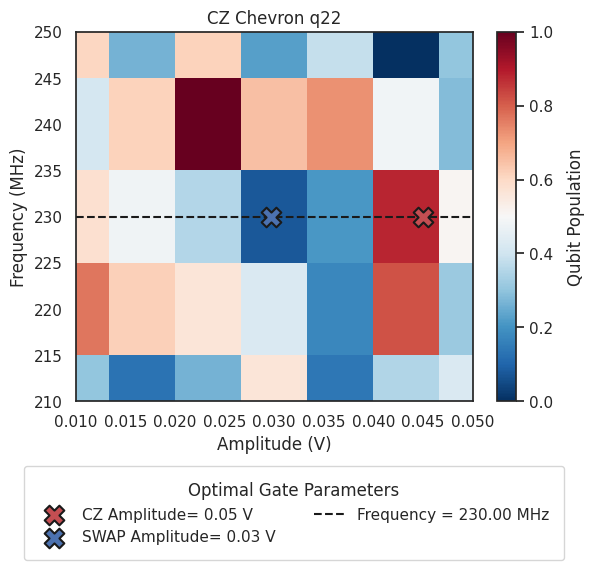

In [ ]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
# plt.figure(figsize=(10,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
plt.scatter(opt_cz,opt_freq,c='r',label = 'CZ Amplitude= {:.2f} V'.format(opt_cz),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP Amplitude= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
plt.legend(loc = 'lower center', bbox_to_anchor=(-0.15, -0.45, 1.4, .102), mode='expand', ncol=2,
            title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('Qubit Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Amplitude (V)')
plt.ylabel('Frequency (MHz)')
plt.title(f'CZ Chevron {qubit}')
plt.show()

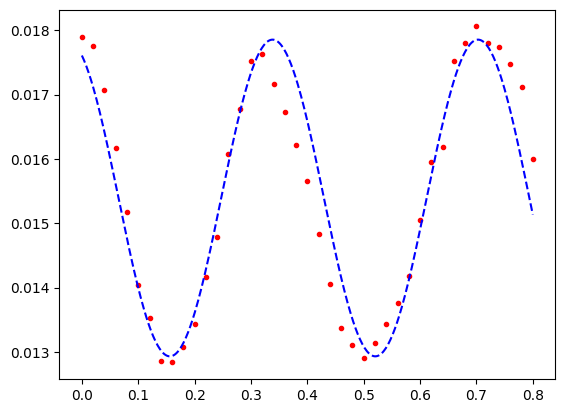

In [ ]:
model = ChevronModel()
magnitude = np.transpose(values)[11]
fit_amplitudes = np.linspace( y[0], y[-1], 400)
guess = model.guess(magnitude, drive_amp=y)
fit_result = model.fit(magnitude, params=guess, drive_amp=y)
fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
# fit_results.append(fit_result)
plt.plot(y,magnitude,'.r')
plt.plot(fit_amplitudes,fit_y,'--b')

In [ ]:
fit_result

In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
couplers = ['q11_q12']
for coupler in couplers: 
    print(f"Coupler parameters {coupler}:")
    redis_config = redis_connection.hgetall(f"couplers:{coupler}")
    # Print the redis config line by line
    for key, value in redis_config.items():
        print(f"{key}: {value}")

Coupler parameters q11_q12:
ro_acq_delay: 2e-07
ro_freq: nan
ro_freq_1: nan
ro_freq_2: nan
ro_freq_opt: nan
ro_ampl_opt: nan
ro_pulse_amp_opt: nan
freq_01: nan
freq_12: nan
anharmonicity: nan
mw_amp180: nan
mw_motzoi: nan
mw_ef_amp180: nan
fidelity: nan
discriminator: nan
t1_time: nan
selectivity: nan
ro_ampl: nan
cz_pulse_frequency: nan
cz_pulse_amplitude: nan
cz_pulse_duration: nan
cz_pulse_width: nan
dc_flux: nan
dc_flux_offset: nan
dc_flux_0: nan
ro_pulse_delay: 4e-09
ro_pulse_duration: 3e-06
ro_acq_integration_time: 2.5e-06
mw_pulse_duration: 2e-08
init_duration: 0.0003
min_calibration_point: 0
max_calibration_point: 0
spec_pulse_duration: 5e-06
spec_amp: 0.0003
att: 0
artificial_detuning: 3000000.0


In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q11','q12','q13','q14','q15']
# qubits = [ 'q15']
qubit_freq_01_list,qubit_freq_ro_list = {},{}
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    for key, value in redis_config.items():
        print(f"{key}: {value}")
    # print(f"mw_amp180: {redis_config['mw_amp180']}")

Qubit parameters q11:
ro_acq_delay: 2e-07
ro_freq: 6934489792.840477
ro_freq_1: 6934335589.10094
ro_freq_2: 6934149227.425686
ro_freq_opt: nan
ro_ampl_opt: nan
ro_pulse_amp_opt: nan
freq_01: 3714909311.9558687
freq_12: 3480498083.2063527
anharmonicity: nan
mw_amp180: 0.21904175817715849
mw_motzoi: -0.23333333333333334
mw_ef_amp180: 0.12059955295547596
fidelity: nan
discriminator: nan
t1_time: nan
selectivity: nan
ro_ampl: nan
ro_pulse_delay: 4e-09
ro_pulse_duration: 3e-06
ro_acq_integration_time: 2.5e-06
mw_pulse_duration: 2e-08
init_duration: 0.0003
min_calibration_point: 0
max_calibration_point: 0
spec_pulse_duration: 5e-06
spec_amp: 0.0003
att: 0
ro_pulse_amp: 0.02
artificial_detuning: 3000000.0
cz_pulse_frequency: nan
cz_pulse_amplitude: nan
cz_pulse_duration: nan
cz_pulse_width: nan
dc_flux: nan
dc_flux_0: nan
dc_flux_offset: nan
Qubit parameters q12:
ro_acq_delay: 2e-07
ro_freq: 6606599823.915397
ro_freq_1: 6606218132.222552
ro_freq_2: 6606624756.803857
ro_freq_opt: nan
ro_ampl_o

In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q11','q12']
f01,f12 = [],[]
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    f01.append(redis_config['freq_01'])
    f12.append(redis_config['freq_12'])
f01,f12 = np.array(f01).astype(float),np.array(f12).astype(float)

Qubit parameters q11:
3714853914.3602576
3448909227.620381
Qubit parameters q12:
3366602683.94394
3366889792.3964834


In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q11','q12','q13','q14','q15']
qubit_freq_01_list,qubit_freq_ro_list,qubit_freq_12_list = {},{},{}
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['ro_freq'])
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    qubit_freq_ro_list[qubit] = redis_config['ro_freq']
    qubit_freq_01_list[qubit] = redis_config['freq_01']
    qubit_freq_12_list[qubit] = redis_config['freq_12']

Qubit parameters q11:
6934516975.164495
3714911395.272988
3480219551.7001905
Qubit parameters q12:
6606536408.043257
3366876737.283394
3173925442.741397
Qubit parameters q13:
6688260738.410758
3584949401.0760307
3343692876.3960423
Qubit parameters q14:
6331293538.718747
3334050785.172637
3133039498.0560727
Qubit parameters q15:
6933733842.658668
3872848429.703217
3631777894.9530077


In [ ]:
from config_files.VNA_values import VNA_resonator_frequencies, VNA_f01_frequencies, VNA_f12_frequencies
for qubit in qubits:
    VNA_resonator_frequencies[qubit] = float(qubit_freq_ro_list[qubit])
    VNA_f01_frequencies[qubit] = float(qubit_freq_01_list[qubit])
    VNA_f12_frequencies[qubit] = float(qubit_freq_12_list[qubit])
# rewrite the VNA_values.py file
with open('config_files/VNA_values.py', 'w') as f:
    f.write(f"VNA_resonator_frequencies = {VNA_resonator_frequencies}\n")
    f.write(f"VNA_f01_frequencies = {VNA_f01_frequencies}\n")
    f.write(f"VNA_f12_frequencies = {VNA_f12_frequencies}\n")

In [ ]:
VNA_resonator_frequencies

{'q11': 6934516975.164495,
 'q12': 6606536408.043257,
 'q13': 6688260738.410758,
 'q14': 6331293538.718747,
 'q15': 6933733842.658668,
 'q16': 6491000000.0,
 'q17': 7059000000.0,
 'q18': 6712000000.0,
 'q19': 6818000000.0,
 'q20': 6494000000.0,
 'q21': 6751000000.0,
 'q22': 6477000000.0,
 'q23': 7052000000.0,
 'q24': 6583000000.0,
 'q25': 6853000000.0}

In [ ]:
VNA_f01_frequencies

{'q11': 3714911395.272988,
 'q12': 3366876737.283394,
 'q13': 3584949401.0760307,
 'q14': 3334050785.172637,
 'q15': 3872848429.703217,
 'q16': 3189000000.0,
 'q17': 3932000000.0,
 'q18': 3254000000.0,
 'q19': 3921000000.0,
 'q20': 3333000000.0,
 'q21': 3773000000.0,
 'q22': 3326000000.0,
 'q23': 3911000000.0,
 'q24': 3271000000.0,
 'q25': 4009000000.0}

In [ ]:
VNA_f12_frequencies

{'q11': 3480219551.7001905,
 'q12': 3173925442.741397,
 'q13': 3343692876.3960423,
 'q14': 3133039498.0560727,
 'q15': 3631777894.9530077,
 'q16': 2993000000.0,
 'q17': 3699000000.0,
 'q18': 3154000000.0,
 'q19': 3682000000.0,
 'q20': 3233000000.0,
 'q21': 3542000000.0,
 'q22': 3131000000.0,
 'q23': 3674000000.0,
 'q24': 3171000000.0,
 'q25': 3770000000.0}

In [ ]:
# dict values to array
(np.array(list(VNA_f12_frequencies.values()))-np.array(list(VNA_f01_frequencies.values()))) / 1e6


array([-234.69184357, -192.95129454, -241.25652468, -201.01128712,
       -241.07053475, -196.        , -233.        , -100.        ,
       -239.        , -100.        , -231.        , -195.        ,
       -237.        , -100.        , -239.        ])

In [ ]:
VNA_resonator_frequencies = {'q11': 6934516975.164495, 'q12': 6606536408.043257, 'q13': 6688260738.410758, 'q14': 6331293538.718747, 'q15': 6933733842.658668, 'q16': 6491000000.0, 'q17': 7059000000.0, 'q18': 6712000000.0, 'q19': 6818000000.0, 'q20': 6494000000.0, 'q21': 6751000000.0, 'q22': 6477000000.0, 'q23': 7052000000.0, 'q24': 6583000000.0, 'q25': 6853000000.0}
VNA_f01_frequencies = {'q11': 3714911395.272988, 'q12': 3366876737.283394, 'q13': 3584949401.0760307, 'q14': 3334050785.172637, 'q15': 3872848429.703217, 'q16': 3189000000.0, 'q17': 3932000000.0, 'q18': 3254000000.0, 'q19': 3921000000.0, 'q20': 3333000000.0, 'q21': 3773000000.0, 'q22': 3326000000.0, 'q23': 3911000000.0, 'q24': 3271000000.0, 'q25': 4009000000.0}
VNA_f12_frequencies = {'q11': 3480219551.7001905, 'q12': 3173925442.741397, 'q13': 3343692876.3960423, 'q14': 3133039498.0560727, 'q15': 3631777894.9530077, 'q16': 2993000000.0, 'q17': 3699000000.0, 'q18': 3154000000.0, 'q19': 3682000000.0, 'q20': 3233000000.0, 'q21': 3542000000.0, 'q22': 3131000000.0, 'q23': 3674000000.0, 'q24': 3171000000.0, 'q25': 3770000000.0}
